In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dilakshanchandrasena/dog-breed-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-breed-classification


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
# datasets
labels = pd.read_csv("/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_data.csv")
sample = pd.read_csv("/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/sample_submission.csv")

# folders paths
train_path = "/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_images"
test_path = "/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/test_images"

In [4]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels["id"][0]

'000bec180eb18c7604dcecc8fe0dba07'

In [6]:
def to_jpg(id):
    return id+".jpg"


labels['id'] = labels['id'].apply(to_jpg)

In [7]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [8]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

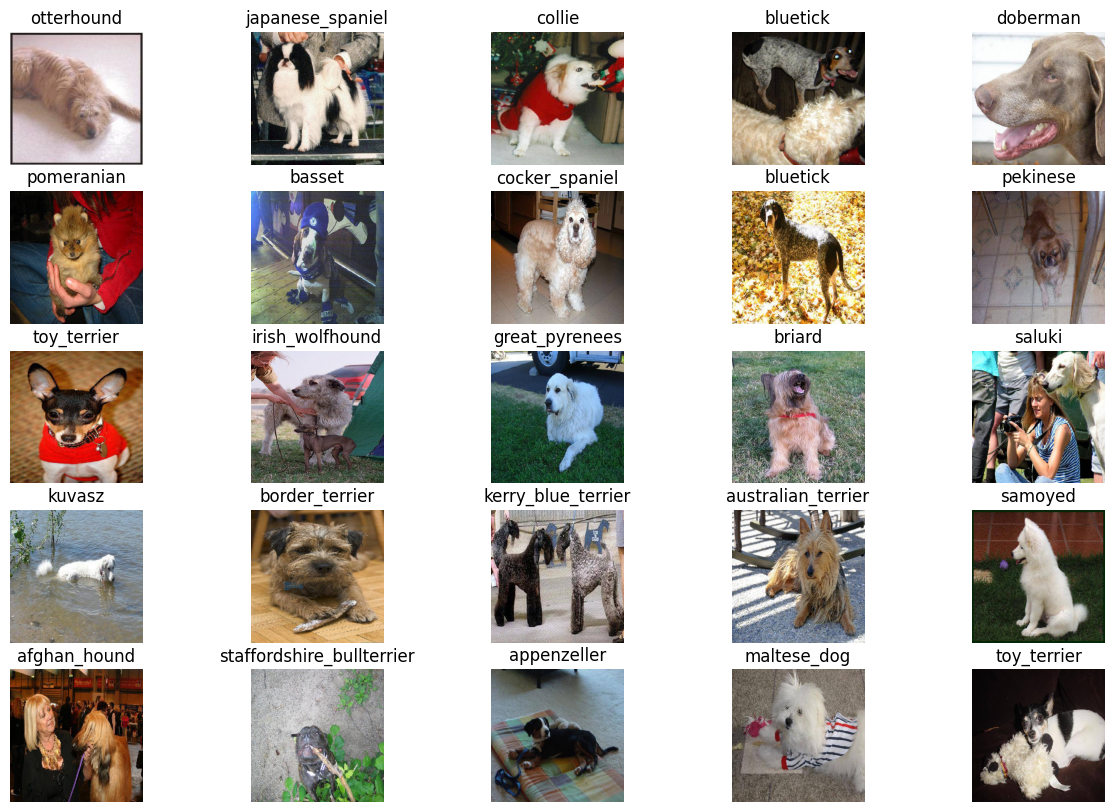

In [9]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [10]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(331,331,3))

base_model.trainable=False

# Build the model and pass an input with a defined shape
# so the model can infer the shapes of all the layers
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)

# Now build the rest of the model
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 9, 9, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,309,528 (210.99 MB)

 Trainable params: 969,720 (3.70 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [13]:
early = tf.keras.callbacks.EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True)
# early stopping call back

In [15]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [ ]:
# fit model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=validation_generator,validation_steps=STEP_SIZE_VALID,epochs=25,callbacks=[early])

In [ ]:
model.save("Model.h5")

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

In [ ]:
test_img_path = "/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/test_images/n02085620_10621.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
sample.id

In [ ]:
predictions = []

for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)

# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output